In [1]:
import torch
import time
import gc
import math
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pickle
import random
from torchvision import transforms

from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim

import sys
sys.path.append('../code')
from python.commons import full_inference_e2e, inc_inference_e2e, adaptive_drilldown, generate_heatmap
from python.imagenet_classes import class_names
from python.vgg16 import VGG16
from python.resnet18 import ResNet18
from python.inception3 import Inception3

random.seed(45)
np.random.seed(45)

torch.set_num_threads(8)

image_file_path = "../code/python/dog_resized.jpg"

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
patch_size = 16
stride = 1
gpu = True

In [3]:
if gpu:
    torch.cuda.synchronize()

prev_time = time.time()
with torch.no_grad():
    x, prob, logit_index = full_inference_e2e(ResNet18, image_file_path, patch_size, stride, batch_size=128, gpu=gpu)
#     x, prob, logit_index = full_inference_e2e(Inception3, image_file_path, patch_size, stride,
#                            batch_size=128, gpu=gpu, image_size=299, x_size=299, y_size=299)

if gpu:
    torch.cuda.synchronize()

full_inference_time = time.time() - prev_time
print("Full Inference Time: " + str(full_inference_time))

Full Inference Time: 21.4507930279


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


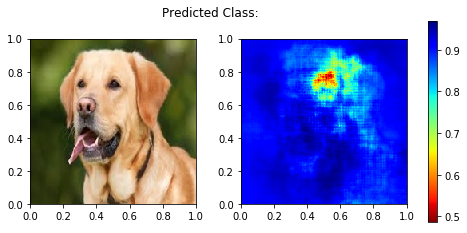

In [4]:
orig_hm  =  generate_heatmap(image_file_path, x, show=True, width=224, alpha=1.0, label=class_names[logit_index],
                             prob=prob)

output = open('temp', 'w')
pickle.dump(orig_hm, output)
output.close()

In [5]:
gc.collect()
torch.cuda.empty_cache()

In [6]:
def inc_inference(beta, patch_size=4, stride=1, adaptive=False):
    if gpu:
        torch.cuda.synchronize()
    
    if not adaptive:
        with torch.no_grad():
            x, prob, logit_index = inc_inference_e2e(ResNet18, image_file_path, patch_size, stride,
                                  batch_size=256, beta=beta, gpu=gpu, version='v1')#,
#                                  image_size=299, x_size=299, y_size=299)
    else:
        with torch.no_grad():
            x, prob, logit_index = adaptive_drilldown(ResNet18, image_file_path, patch_size, stride,
                                    batch_size=256, beta=beta, percentile=20)
    if gpu:
        torch.cuda.synchronize()

    return x, prob, logit_index

BETA: 1.0 Inference Time: 14.1158850193


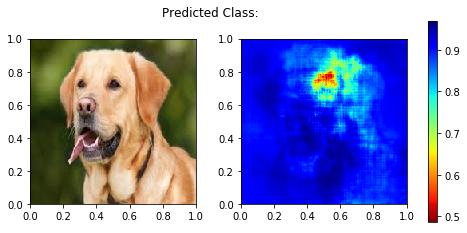

BETA: 0.9 Inference Time: 12.530600071


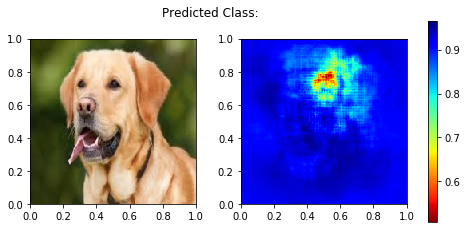

BETA: 0.8 Inference Time: 11.9123411179


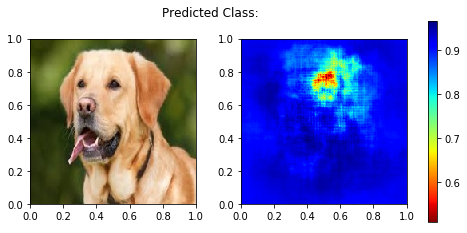

BETA: 0.7 Inference Time: 9.74107503891


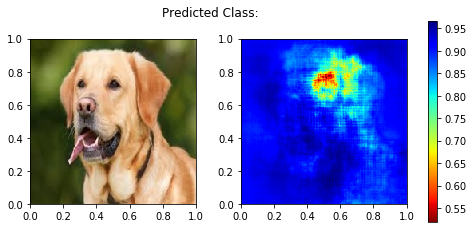

BETA: 0.6 Inference Time: 8.48638701439


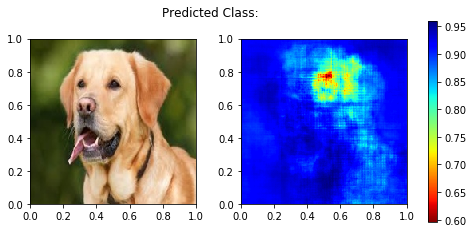

BETA: 0.5 Inference Time: 7.78992605209


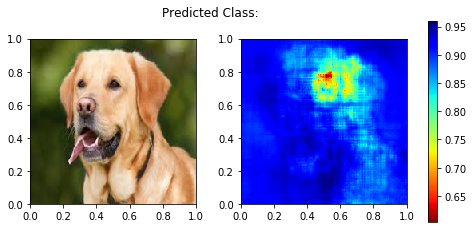

BETA: 0.4 Inference Time: 6.45806002617


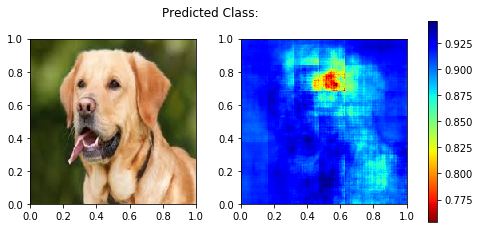

In [7]:
orig_hm = pickle.load(open('temp', 'r'))

times = []
score = []

taus = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]

for beta in taus:
    prev_time = time.time()
    x, prob, logit_index = inc_inference(beta, patch_size=patch_size, stride=stride)
    inc_inference_time = time.time()-prev_time
    times.append(inc_inference_time)
    
    label = "BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    hm = generate_heatmap(image_file_path, x, show=True, width=224, alpha=1.0, label=class_names[logit_index], prob=prob)
    
    if hm.shape[0] < 7:
        win_size=3
    else:
        win_size=None
    
    score.append(ssim(orig_hm, hm, data_range=255, multichannel=True, win_size=win_size))

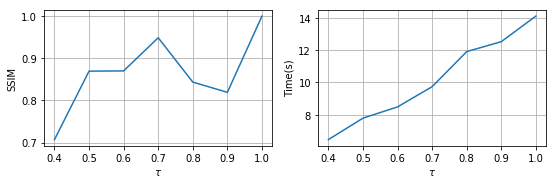

In [8]:
plt.figure(figsize=(9,2.5))

plt.subplot(1,2,1)
plt.plot(taus, score)
plt.ylabel('SSIM')
plt.xlabel(r'$\tau$')
plt.grid()

plt.subplot(1,2,2)
plt.plot(taus, times)
plt.ylabel('Time(s)')
plt.xlabel(r'$\tau$')
plt.grid()

plt.show()

In [9]:
def inc_inference_selected(model, file_path, patch_size, stride, patch_positions, batch_size=64, beta=1.0, x0=0, y0=0, image_size=224,
                      x_size=224, y_size=224, gpu=True, version='v1', n_labels=1000, weights_data=None,
                           loader=None, c=0.0):

    if loader == None:
        loader = transforms.Compose([transforms.Resize([image_size, image_size]), transforms.ToTensor()])
    orig_image = Image.open(file_path).convert('RGB')
    orig_image = loader(orig_image).unsqueeze(0)

    if gpu:
        orig_image = orig_image.cuda()

    image_patches = torch.FloatTensor(3, patch_size, patch_size).fill_(c).repeat(batch_size, 1, 1, 1)
        
    x_output_width = int(math.ceil((x_size*1.0 - patch_size) / stride))
    y_output_width = int(math.ceil((y_size*1.0 - patch_size) / stride))

    total_number = x_output_width * y_output_width
    logit_values = np.zeros((x_output_width, y_output_width), dtype=np.float32)
    
    num_batches = int(math.ceil(len(patch_positions) * 1.0 / batch_size))
    inc_model = model(beta=beta, gpu=gpu, n_labels=n_labels, weights_data=weights_data).eval()
    
    if gpu:
        inc_model = inc_model.cuda()
        
    logit_index = np.argmax(inc_model.forward_materialized(orig_image).cpu().data.numpy())
 
    locations = torch.zeros([batch_size, 2], dtype=torch.int32)
    
    for i in range(num_batches):
        for j in range(batch_size):
            index = j * num_batches + i
            if index >= len(patch_positions):
                break

            x, y = patch_positions[index]
            x = x*stride + x0
            y = y*stride + y0
            x,y = int(x), int(y)
            
            locations[j, 0] = x
            locations[j, 1] = y

        if version == 'v1':
            logits = inc_model.forward_gpu(image_patches, locations, p_height=patch_size, p_width=patch_size)
        else:
            logits = inc_model.forward_pytorch(image_patches, locations, p_height=patch_size, p_width=patch_size)
            
        logits = logits.cpu().data.numpy()[:, logit_index].flatten().tolist()

        for logit, j in zip(logits, range(batch_size)):
            index = j * num_batches + i
            if index >= len(patch_positions):
                break
            x, y = patch_positions[index]
            logit_values[x, y] = logit

    del inc_model
    gc.collect()

    return logit_values, prob, logit_index



def adaptive_drilldown(model, file_path, patch_size, stride, batch_size=128, image_size=224, beta=1.0, percentile=75, gpu=True, version='v1',
                       n_labels=1000, weights_data=None, loader=None):
    final_out_width = int(math.ceil((image_size*1.0-patch_size)/stride))
    #checking for interested regions
    temp1, prob, logit_index = inc_inference_e2e(model, file_path, max(16, patch_size), max(8, patch_size/2),
                                    batch_size=batch_size, beta=beta, image_size=image_size, x_size=image_size,
                              y_size=image_size, gpu=gpu, version=version, weights_data=weights_data, loader=loader)

    temp1 = cv2.resize(temp1, (final_out_width, final_out_width), interpolation=cv2.INTER_LINEAR)
    threshold = np.percentile(temp1, percentile)
    temp1 = np.where(temp1 >= threshold, temp1, 0) 
    idx = np.argwhere(temp1 <= threshold)
    
    #drilldown into interested regions
    temp2, prob, logit_index = inc_inference_selected(model, file_path, patch_size, stride, idx.tolist(),
                                    batch_size=batch_size, beta=beta, image_size=image_size,
                              x_size=image_size, y_size=image_size, gpu=gpu, version=version,
                            weights_data=weights_data, loader=loader)

    
    
    return np.add(temp1, temp2), prob, logit_index

BETA: 1.0 Inference Time: 3.59588217735


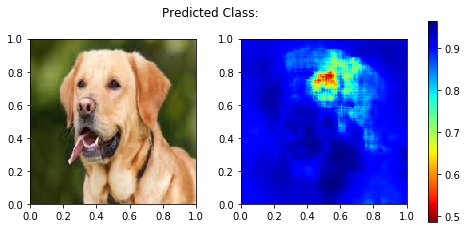

BETA: 0.9 Inference Time: 3.23177504539


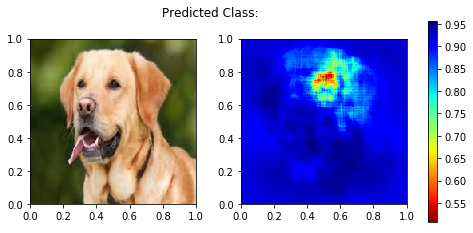

BETA: 0.8 Inference Time: 3.07603192329


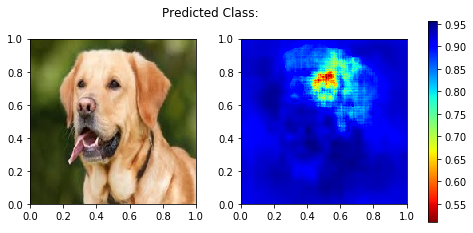

BETA: 0.7 Inference Time: 2.58290696144


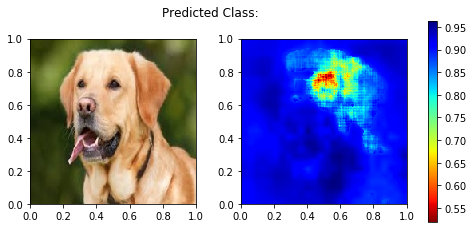

BETA: 0.6 Inference Time: 2.26758694649


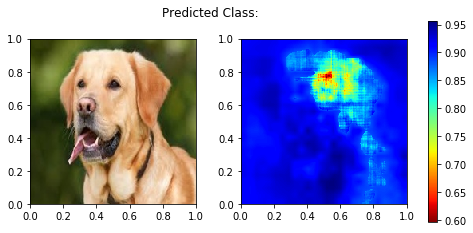

BETA: 0.5 Inference Time: 2.14197802544


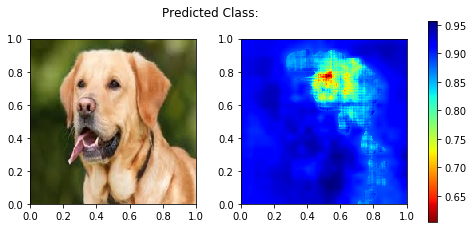

BETA: 0.4 Inference Time: 1.83693814278


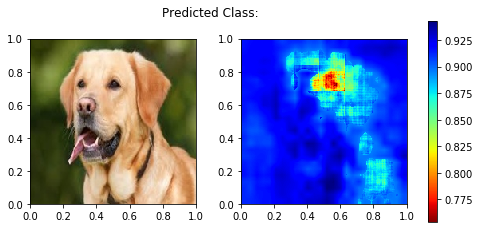

In [10]:
orig_hm = pickle.load(open('temp', 'r'))

times = []
score = []

taus = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]

for beta in taus:
    prev_time = time.time()
    x, prob, logit_index = inc_inference(beta, patch_size=patch_size, stride=stride, adaptive=True)
    inc_inference_time = time.time()-prev_time
    times.append(inc_inference_time)
    
    label = "BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    hm = generate_heatmap(image_file_path, x, show=True, width=224, alpha=1.0, label=class_names[logit_index], prob=prob)
    
    if hm.shape[0] < 7:
        win_size=3
    else:
        win_size=None
    
    score.append(ssim(orig_hm, hm, data_range=255, multichannel=True, win_size=win_size))

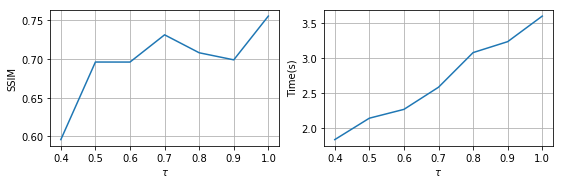

In [11]:
plt.figure(figsize=(9,2.5))

plt.subplot(1,2,1)
plt.plot(taus, score)
plt.ylabel('SSIM')
plt.xlabel(r'$\tau$')
plt.grid()

plt.subplot(1,2,2)
plt.plot(taus, times)
plt.ylabel('Time(s)')
plt.xlabel(r'$\tau$')
plt.grid()

plt.show()